<a href="https://colab.research.google.com/github/ankitstar01/2048-ai/blob/master/Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
!pip install polygon-api-client 
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from polygon import RESTClient
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping

In [6]:
api_key = 'vqeohd8x5k1x6PKiisJQS8RgS3A1iRQC'
TIME_HORIZON = 10
current_day = datetime.today().strftime('%Y-%m-%d')
loss_function = 'mean_squared_error'
activation_function = 'relu'
optimizer = 'adam'
record_limit = 50000
timespan = 'minute'
asc_sorting_order = 'asc'
desc_sorting_order = 'desc'
start_date = (datetime.today() - timedelta(days=80)).strftime('%Y-%m-%d')
to_date = (datetime.today() - timedelta(days=2)).strftime('%Y-%m-%d')

# folder path variables
model_folder_path = 'Models/'
historic_folder_path = 'Data/Historic/'
recent_folder_path = 'Data/Recent/'
file_extension = '.csv'
historic_file_header = 'timestamp,open,low,high,volume,close\n'
recent_file_header = 'open,low,high,volume,close\n'

# plot variables
stock_price_label = 'Stock Price'
real_label = 'Real'
predicted_label = 'Predicted'
x_label = 'time'
answers_colour = 'r'
prediction_colour = 'c'

ticker = 'GME'
time_horizon = 10
time_span = 'minute'
key = 'vqeohd8x5k1x6PKiisJQS8RgS3A1iRQC'

In [7]:

def get_historic_data(ticker, time_horizon, time_span, key):
    f = open(historic_folder_path + ticker + file_extension, 'w')
    with RESTClient(key) as client:
        resp = client.stocks_equities_aggregates(ticker=ticker, multiplier=time_horizon, timespan=time_span,
                                                 from_=start_date, to=to_date, unadjusted=False,
                                                 sort=asc_sorting_order, limit=record_limit)
        resp = resp.results
        f.write(historic_file_header)
        for query in resp:
            f.write(str(query['t']) + ',' + str(query['o']) + ',' + str(query['l']) + ','
                    + str(query['h']) + ',' + str(query['v']) + ',' + str(query['c']) + '\n')
    f.close()
    f = open(historic_folder_path + ticker + file_extension, 'r')
    df = pd.read_csv(f)
    return df

In [68]:

def preprocess_training_data(training_df):
    training_df = training_df.drop(['timestamp'], axis=1)
    scaler = MinMaxScaler()
    scaler_df = training_df.copy()
    scaler.fit_transform(scaler_df)
    scaler = scaler.scale_
    training_df['open'] *= scaler[0]
    training_df['low'] *= scaler[1]
    training_df['high'] *= scaler[2]
    training_df['volume'] *= scaler[3]
    training_df['close'] *= scaler[4]

    x_train, y_train = [], []
    training_df = np.asarray(training_df)
    for i in range(15, training_df.shape[0]):
        x_train.append(training_df[i - 15: i])
        y_train.append(training_df[i, 0])
    x_train, y_train,xv,yv , x_test,y_test = np.asarray(x_train[:-120]), np.asarray(y_train[:-120]),np.array(x_train[-120:-60]), np.array(y_train[-120:-60]),np.asarray(x_train[-60:]), np.asarray(y_train[-60:])
    return x_train, y_train,xv,yv,x_test,y_test, scaler

In [347]:

def get_recent_data(ticker, key, time_horizon, time_span):
    f = open(recent_folder_path + ticker + file_extension, 'w')
    with RESTClient(key) as client:
        resp = client.stocks_equities_aggregates(ticker=ticker, multiplier=time_horizon, timespan=time_span,
                                                 from_=to_date, to=current_day, unadjusted=False,
                                                 sort=asc_sorting_order, limit=record_limit)
        resp = resp.results
        f.write(historic_file_header)
        for query in resp:
            f.write(str(query['t']) + ',' + str(query['o']) + ',' + str(query['l']) + ','
                    + str(query['h']) + ',' + str(query['v']) + ',' + str(query['c']) + '\n')
    f.close()

def update_recent_data(ticker, key, time_horizon, time_span):
    f = open(recent_folder_path + ticker + file_extension, 'a')
    with RESTClient(key) as client:
        resp = client.stocks_equities_aggregates(ticker=ticker, multiplier=time_horizon, timespan=time_span,
                                                 from_=to_date, to=current_day, unadjusted=False,
                                                 sort=desc_sorting_order, limit=record_limit)
        query = resp.results[0]
        f.write(str(query['t']) + ',' + str(query['o']) + ',' + str(query['l']) + ','
                + str(query['h']) + ',' + str(query['v']) + ',' + str(query['c']) + '\n')
    f.close()
    f = open(recent_folder_path + ticker + file_extension, 'r')
    entry_price = query['o']
    recent_df = pd.read_csv(f)
    return recent_df, entry_price

def preprocess_recent_data(recent_df, scaler):
    recent_df = recent_df.drop(['timestamp'], axis=1)
    recent_df['open'] *= scaler[0]
    recent_df['low'] *= scaler[1]
    recent_df['high'] *= scaler[2]
    recent_df['volume'] *= scaler[3]
    recent_df['close'] *= scaler[4]
    df = [recent_df[-15:]]
    df = np.asarray(df)
    return df
def visualize_model(predictions, answers, ticker):
    plt.figure(figsize=(15, 5))
    plt.plot(answers, c=answers_colour, label=real_label + ' ' + ticker + ' ' + stock_price_label)
    plt.plot(predictions, c=prediction_colour, label=predicted_label + ' ' + ticker + ' ' + stock_price_label)
    plt.xlabel(x_label)
    plt.ylabel(ticker + ' ' + stock_price_label)
    plt.legend()
    plt.show()

def create_model(ticker, training_input, training_output, scaler):
    model = Sequential()
    model.add(LSTM(units=50, activation=activation_function, input_shape=(15, 5), return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units=60, activation=activation_function, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units=80, activation=activation_function, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units=100, activation=activation_function, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units=120, activation=activation_function, return_sequences=False))
    model.add(Dropout(0.1))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss=loss_function)
    es=EarlyStopping(monitor='val_loss',mode='min',patience=7,verbose=1)
    model.fit(training_input, training_output,validation_data=(xv,yv), epochs=100, batch_size=32,verbose=1,callbacks=[es])
    model.save(model_folder_path + ticker)
    pred=model.predict(training_input, training_output)
    return pred,training_output
def hr_create_modelm(ticker, training_input, training_output, scaler):
    model = Sequential()
    model.add(LSTM(units=50, activation=activation_function, input_shape=(15, 5), return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units=60, activation=activation_function, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units=80, activation=activation_function, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units=100, activation=activation_function, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units=120, activation=activation_function, return_sequences=False))
    model.add(Dropout(0.1))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss=loss_function)
    es=EarlyStopping(monitor='val_loss',mode='min',patience=7,verbose=1)
    model.fit(training_input, training_output,validation_data=(xv,yv), epochs=100, batch_size=32,verbose=1,callbacks=[es])
    pred=model.predict(training_input, training_output)
    return pred,training_output
def min_create_model(ticker, training_input, training_output, scaler):
    model = Sequential()
    model.add(LSTM(units=50, activation=activation_function, input_shape=(15, 5), return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units=60, activation=activation_function, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units=80, activation=activation_function, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units=100, activation=activation_function, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units=120, activation=activation_function, return_sequences=False))
    model.add(Dropout(0.1))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss=loss_function)
    es=EarlyStopping(monitor='val_loss',mode='min',patience=7,verbose=1)
    model.fit(training_input, training_output,validation_data=(xv,yv), epochs=100, batch_size=32,verbose=1,callbacks=[es])
    model.save(model_folder_path + 'min_' + ticker)
    pred=model.predict(training_input, training_output)
    return pred,training_output

In [348]:
# !mkdir data
# !cd data

def get_prediction(model, scaler, last_data):
    prediction = model.predict(last_data)
    prediction *= 1/scaler[0]
    return prediction

def convert_timestamp(timestamp):
    return datetime.fromtimestamp(timestamp/1000)

In [357]:
dfm=pd.read_csv('data/Historic/minuteGME.csv')
dfm['timestamp']=dfm['timestamp'].apply(lambda x:datetime.fromtimestamp(x/1000))
dfm.tail()

,timestamp,open,low,high,volume,close
4446,2021-02-12 00:10:00,50.15,50.15,50.25,2615.0,50.15
4447,2021-02-12 00:20:00,50.08,50.08,50.20,2978.0,50.08
4448,2021-02-12 00:30:00,50.18,50.15,50.19,2629.0,50.15
4449,2021-02-12 00:40:00,50.18,50.05,50.20,9062.0,50.06
4450,2021-02-12 00:50:00,50.20,50.15,50.50,14792.0,50.28


In [350]:
x_train, y_train,xv,yv,x_test,y_test, scaler = preprocess_training_data(df)
print(x_train.shape,xv.shape,x_test.shape)
print(y_train.shape,yv.shape,y_test.shape)
print(scaler)

(4316, 15, 5) (60, 15, 5) (60, 15, 5)
(4316,) (60,) (60,)
[2.08800176e-03 2.13739153e-03 1.99688486e-03 6.63050873e-08
 2.07125104e-03]


In [355]:
# pred,ans = min_create_model(ticker, x_train, y_train, scaler)
pred=model.predict(x_test)


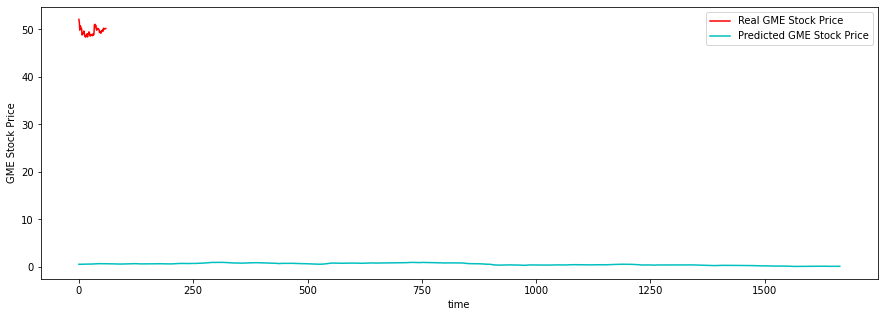

In [356]:
visualize_model(predictions, y_test, ticker)

In [352]:
model = keras.models.load_model('Models/' + ticker)
model.evaluate(x_test,y_test)

2/2 [==============================] - 1s 15ms/step - loss: 2.3562e-04


0.00023562194837722927

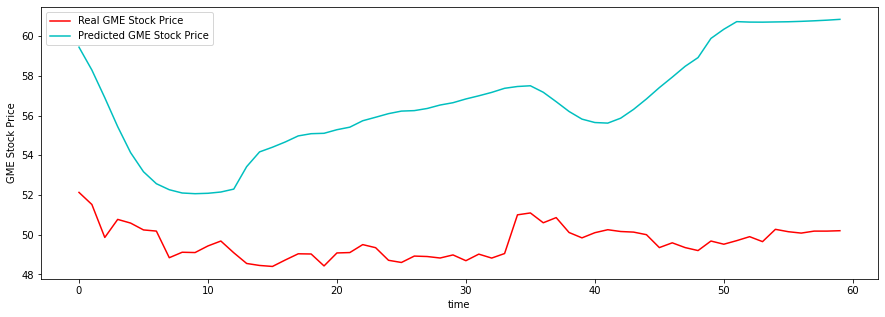

In [353]:
pred=model.predict(x_test)
pred=pred/scaler[0]
y_test=y_test/scaler[0]
visualize_model(pred,y_test,ticker)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


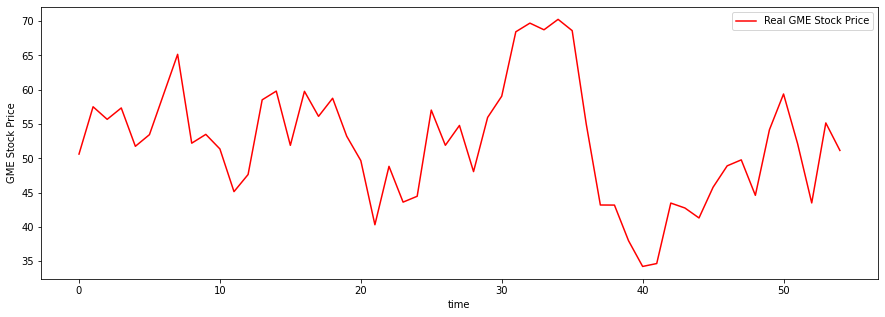

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


array([52.33558], dtype=float32)

In [354]:
prob=[]
def r(x,y):
  if(y/x>1.5):
    return 1.5
  elif(y/x<-1.4):
    return (-1.4)
  else:
    return y/x
def probablity(pred,y_test):
  for j in range(5,60):
    p=50
    for i in range(j-5,j):
      pp=(pred[i]-pred[i-1])/pred[i-1]
      tp=(y_test[i]-y_test[i-1])/y_test[i-1]
      if(r(pp,tp)<0):
        p=p+(p)*(r(pp,tp)/10)
      else:
        p=p+(100-p)*(r(pp,tp)/10)
      # p=p+(p)*(r(pp,tp)/10)
    prob.append(p)
  return prob
prob=probablity(pred,y_test)
plt.figure(figsize=(15, 5))
plt.plot(prob, c=answers_colour, label=real_label + ' ' + ticker + ' ' + stock_price_label)
plt.xlabel(x_label)
plt.ylabel(ticker + ' ' + stock_price_label)
plt.legend()
plt.show()
np.array(prob).mean()

In [316]:
pred

In [279]:
p=10
p1=30
p2=10
p3=10
x=(p1-p)/p
y=(p3-p2)/p2
print(r(x,y))

0.0


In [ ]:
df2 = df2.drop(["timestamp"], axis=1)
df2.tail()

,open,low,high,volume,close
3191,50.18,50.13,50.94,33918.0,50.13
3192,50.13,49.56,50.75,56667.0,50.51
3193,50.73,50.10,50.73,32266.0,50.10
3194,50.10,49.50,50.10,56866.0,49.60
3195,49.60,49.00,49.69,123666.0,49.17


In [ ]:
model = keras.models.load_model('models/' + ticker)
x_train, y_train, x_test, y_test, scaler = split_data(df2)
predictions = model.predict(x_test)

In [ ]:
scale = 1 / scaler
predictions = predictions * scale
y_test = y_test * scale

plt.figure(figsize=(14, 5))
plt.plot(y_test, c='r', label='Real ' + ticker + ' stock price')
plt.plot(predictions, c='b', label='Predicted ' + ticker + ' stock price')
plt.xlabel('time')
plt.ylabel(ticker + ' Stock Price')
plt.legend()
plt.show()

In [57]:
df[-90:-60]

,timestamp,open,low,high,volume,close
1710,2020-10-05 04:00:00,4.3000,4.0500,4.3600,9604945.0,4.13
1711,2020-10-06 04:00:00,4.2600,4.0500,4.2700,8474681.0,4.06
1712,2020-10-07 04:00:00,4.0800,3.9400,4.1100,6988571.0,4.04
1713,2020-10-08 04:00:00,4.1300,4.0200,4.1850,8018632.0,4.14
1714,2020-10-09 04:00:00,4.1700,4.0400,4.1800,5107596.0,4.05
1715,2020-10-12 04:00:00,4.0300,4.0000,4.0900,3312043.0,4.08
1716,2020-10-13 04:00:00,3.9000,3.5200,3.9100,10342266.0,3.54
1717,2020-10-14 04:00:00,3.0900,2.6600,3.2000,32142195.0,2.96
1718,2020-10-15 04:00:00,2.8400,2.7600,2.9600,9949311.0,2.78
1719,2020-10-16 04:00:00,2.8700,2.8000,3.2900,18665138.0,3.04


In [ ]:
def get_minute_data(ticker, api_key, last_minutes):  # gets minute by minute data for last (last_minutes) minutes
    f = open('recent_ticker_data/' + ticker + '.csv', 'w')
    with RESTClient(api_key) as client:
        resp = client.stocks_equities_aggregates(ticker=ticker, multiplier=1, timespan='minute',
                                                 from_='1999-07-12', to='2021-02-04', unadjusted=False,
                                                 sort='desc', limit=last_minutes)
        resp = resp.results
        f.write('timestamp,open,low,high,volume,close\n')
        for query in resp:
            f.write(str(query['t']) + ',' + str(query['o']) + ',' + str(query['l']) + ',' + str(query['h']) + ',' + str(query['v']) + ',' + str(query['c']) + '\n')
        f.close()
    f = open('recent_ticker_data/' + ticker + '.csv', 'r')
    df = pd.read_csv(f)
    return df

In [ ]:
df = get_minute_data('GME', API_KEY, 60)
df.head()

,timestamp,open,low,high,volume,close
0,1612486740000,49.00,49.00,49.48,29415,49.17
1,1612486680000,49.02,49.00,49.10,22745,49.01
2,1612486620000,49.25,49.01,49.25,21123,49.02
3,1612486560000,49.40,49.20,49.40,13707,49.20
4,1612486500000,49.41,49.40,49.56,10718,49.41


In [ ]:
def get_all_news(ticker, api_key):  # function works on pycharm, however google colab cannot open the csv file
    f = open(ticker + '_news.csv', 'w')
    f.write('date,title\n')
    with RESTClient(api_key) as client:
        for j in range(25):
            resp = client.reference_ticker_news(symbol=ticker, perpage=50, page=j)
            for i in range(50):
                f.write(resp.news[i].timestamp + ',' + resp.news[i].title + '\n')
    f.close()

In [ ]:
def get_polarity(headline):
    analysis = TextBlob(headline)
    return analysis.polarity

In [220]:
if 4>3:
  (4)
else:
  3